# Central bank communications with LLM 

In this notebook, we illustrate how to use `Large Language Models` (LLM), in particular models by Openai to extract information for each document of a corpus. The corpus that we will use is the collection of statements by the US Federal Reserve since 1999. 

In particular, given that Openai only proposes commercial LLMs, you need to have created an account and been provided a key. In the cell below you can paste the key: `api_key=sk-...`. Alternatively (as done below), you can put in a file call "key." and call the file. 

In [1]:
import os
del os.environ['http_proxy']
del os.environ['https_proxy']
with open('key', 'r') as f: api_key = f.read()

## Setup 

In [2]:
from tqdm.auto import tqdm 
import pandas as pd
from skfin.plot import *
from skfin.datasets import load_fomc_statements
statements = load_fomc_statements(force_reload=False, cache_dir='../nbs/data')

INFO:skfin.datasets:logging from cache file: ../nbs/data/fomc_statements.parquet


In [3]:
text = statements['text'].iloc[0]
text

"The Federal Reserve released the following statement after today's Federal Open Market Committee meeting: While the FOMC did not take action today to alter the stance of monetary policy, the Committee was concerned about the potential for a buildup of inflationary imbalances that could undermine the favorable performance of the economy and therefore adopted a directive that is tilted toward the possibility of a firming in the stance of monetary policy. Trend increases in costs and core prices have generally remained quite subdued. But domestic financial markets have recovered and foreign economic prospects have improved since the easing of monetary policy last fall. Against the background of already-tight domestic labor markets and ongoing strength in demand in excess of productivity gains, the Committee recognizes the need to be alert to developments over coming months that might indicate that financial conditions may no longer be consistent with containing inflation."

## Openai

We import the `openai` library. Moreover, because Open AI imposes rate restrictions on the number of times a user or client can access the Open AI services within a specified period of time, we wrap the `chat_completion` function with a decorator based on the library `tenacity`.

If these packages are not in the environment, you need to pip install them. 

In [4]:
#pip install openai 
#pip install tenacity 

In [5]:
import openai
openai.api_key = api_key
from tenacity import retry, stop_after_attempt, wait_random_exponential

In [6]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def chat_completion(user, system, model="gpt-3.5-turbo"):
    response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
            temperature=0,
        )
    return response['choices'][0]['message']['content']

In the function above (and the analysis below), the baseline model is `gpt-3.5-turbo`.

## Measuring Hawkishness

With the following prompt, we ask the model to qualify Fed statements in terms of hawkishness/dovishness. We also insist on receiving a single-word answer. 

In [7]:
system_ = """Act as a financial analyst. 
             What is the monetary policy dovishness or hawkishness of this text? Please choose an answer from {hawkish/dovish/neutral/unknown}. 
             You should answer the following question using only one word or all the work will be useless. The value should be one of the possible values I shared.""" 

In [8]:
v = pd.Series({t: chat_completion(statements.loc[t, 'text'], system_) for t in tqdm(statements.index)}).str.lower()
statements_ = statements.join(pd.get_dummies(v, dtype=float))

  0%|          | 0/211 [00:00<?, ?it/s]

Checking that indeed we received at most the four options. (It seems that the models rarely says "I don't know.")

In [9]:
v.value_counts()

dovish     118
hawkish     62
neutral     31
dtype: int64

To get an intuition from the output of the LLM, we problem the cumulative difference of the dummies `hawkish - dovish`. We see clearly the tightening and accomodating phases of monetary policy:

- 1999 - 2001: tightening until the dot-com burst 
- 2001 - 2004: loosening of monetary policy 
- 2004 - 2007: tightening
- 2007 - 2017: long experiment with loosening, including with Quantitative Easing 
- 2017 - 2019: Quantitative tightening
- 2019 - 2021: economic slowdown (2019) preceding the Covid intervention
- 2022 - today: tightening due to high inflation

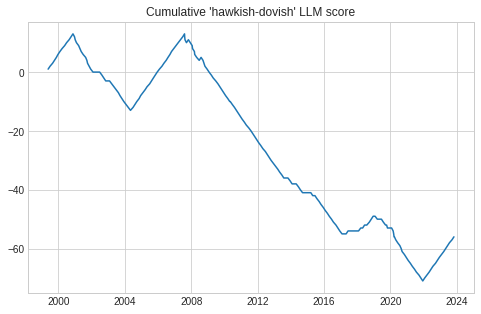

In [10]:
line(statements_.pipe(lambda x: x['hawkish'].sub(x['dovish'])), cumsum=True, legend=False, title="Cumulative 'hawkish-dovish' LLM score")

A similar picture is shown with the rolling 1-year (= 8 FOMC meetings) `hawkish-dovish` LLM score.

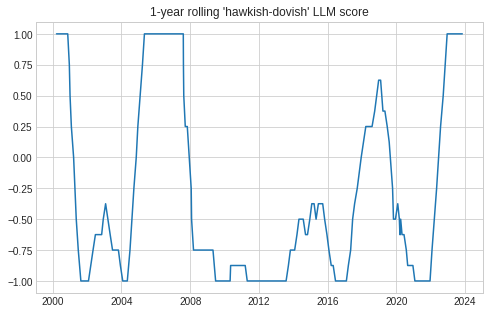

In [11]:
line(statements_.pipe(lambda x: x['hawkish'].sub(x['dovish'])).rolling(window=8).mean(), 
     legend=False, title="1-year rolling 'hawkish-dovish' LLM score")

## Explaining chatgpt hawkishness

Beyond the simple validation of the LLM score in the previous section, we can go deeper and identify the words associated with hawkishness (or dovishness) as interpreted by the language model. To do so, we run a regression where the target is the LLM score and the features are `tfidf` values for the main tokens. 

In [12]:
from skfin.text import show_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from skfin.text import coefs_plot, show_text

In [13]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0075)),
    ]
)

X = statements_["text"]

In [14]:
interpret_coefs = {}
for c in ['hawkish', 'neutral', 'dovish']: 
    y = statements_[c]
    est.fit(X, y)
    vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(np.transpose(est.named_steps["reg"].coef_), index=vocab_)

In [15]:
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}

Words associated to tightening are on the `hawkish` side ("raise target", "pressures", "inflation", etc). A bit more mixed resuts on the other side. 

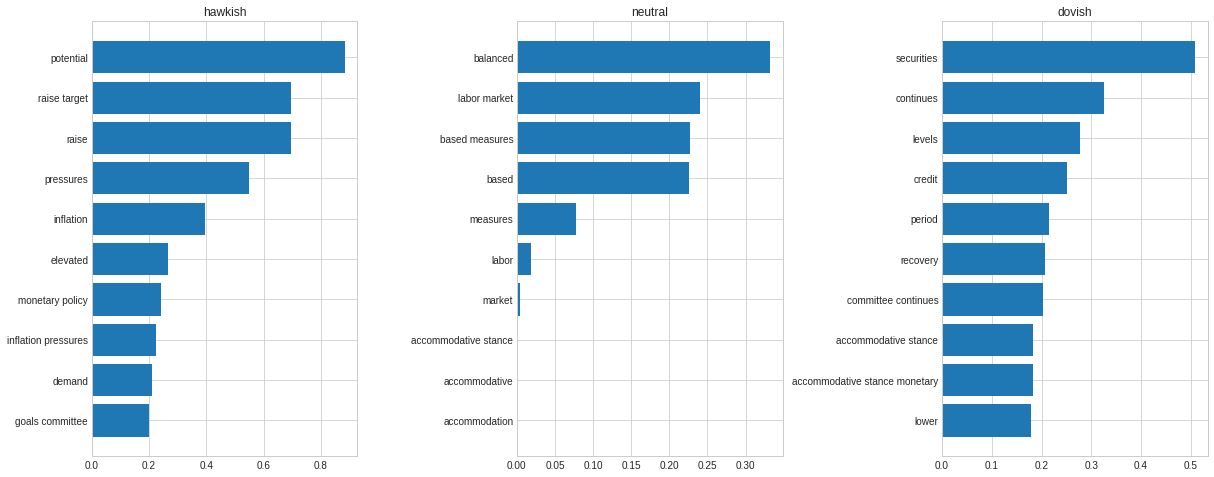

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=.6)
for i, (k, v) in enumerate(d.items()): 
    bar(v, horizontal=True, ax=ax[i], title=k)

## Topics using KeyLLM 

To further study the corpus, we can use LLMs to identify topics in documents. The package `keybert` just does that. 

In [30]:
#pip install keybert 

In [22]:
from keybert.llm import OpenAI
from keybert import KeyLLM

In [23]:
llm = OpenAI()
kw_model = KeyLLM(llm)
keywords = kw_model.extract_keywords(statements['text'].to_list()) 

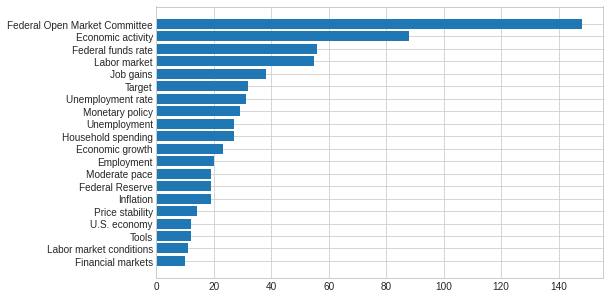

In [24]:
bar(pd.Series([w for v in keywords for w in v if len(w)>0]).value_counts().head(20), horizontal=True)

Below we show the top 3 topics for certain events.

In [25]:
statements_kw = pd.concat([pd.Series(v).iloc[:3] for v in keywords], axis=1).T.set_index(statements.index)

In [27]:
statements_kw.loc['2001-09':'2001-12']

,0,1,2
release_date,,,
2001-09-17,Tragic events,Employment,Production
2001-10-02,Terrorist attacks,Uncertainty,Economy
2001-11-06,Uncertainty,Deterioration,Business conditions
2001-12-11,Economic activity,Inflation,Demand


In [29]:
statements_kw.loc['2020-03']

,0,1,2
release_date,,,
2020-03-03,U.S. economy,Strong,Coronavirus
2020-03-15,Coronavirus,Economic impact,Federal Open Market Committee
2020-03-23,Federal Reserve,Tools,US economy
2020-03-31,Federal Reserve,Temporary repurchase agreement facility,Foreign
